# MSD of a Quasiperiodic Array obtained with various random points

In [1]:
#The following packages are required:
using Plots
using DelimitedFiles
using LinearAlgebra

#The following files are required:
include("Operaciones_Basicas.jl")
include("Red_Dual.jl")
include("Separacion_Arreglos_X_Y.jl")
include("Generador_Vecindades_Pto_Arbitrario.jl")
include("voronoi.jl")
include("Algoritmo_Radio.jl")
include("Algoritmo_Voronoi.jl")
include("Algoritmo_Cluster_Principal_Iterado.jl")
include("Algoritmo_Parche_Cuadrado.jl")
include("Dentro_Fuera_Poligono.jl")
include("Diccionario_Indices_Centroides_Voronoi.jl")
include("Algoritmo_Dinamica.jl")

MSD_Varying_Velocities (generic function with 1 method)

##### Trajectory and interaction potential

In [2]:
include("Esferas_Duras_Trayectoria_Recta.jl")

estado_Tras_Tiempo_Rectas (generic function with 1 method)

##### System Information

In [3]:
#Information of the Quasiperiodic Array
NSides = 5; #Symmetry of the quasiperiodic lattice
Error_Margin = 2; #Margin of error in the GDM of the possible integers
Star_Vectors = [[BigFloat(1),0]]; #Array wich will contain the Star Vectors
for i in 1:(NSides-1)
    push!(Star_Vectors, [cos((2*i)*pi/NSides), sin((2*i)*pi/NSides)]); #Complete the Star_Vector Array
end
Alphas_Array = fill(0.2, NSides); #Array of the alphas constant
Average_Distance_Stripes = fill(NSides/2, NSides); #Array with the average distance between stripes

#Let's read the information of the almost-circular neighborhoods of the system
Patch_Information = readdlm("Informacion_Parche_N_$(NSides).csv", BigFloat);
Reduction_Factor = 0.8; #The factor with which we multiple the Average Radius to generate the Safe Radius

##### Iteration information

In [4]:
#Set the number of different initial position that the algorithm will search.
Number_Positions = 1;

#Set the number of different initial velocities associated to each initial position.
Number_Velocities = 1;

#Set the flying time for all the different particles
Long_Fly_Time = 10000;

#The fly time of each of the fragments that will conform the long fly
Short_Fly_Time = 10;

### Iterates over position

In [5]:
Number_Flights = Int64(Long_Fly_Time/Short_Fly_Time); #The number of short flies that conform a long one
    
#ARRAYS USED IN THE MSD ALGORITHM
Accumulated_Fly_Time = zeros(Number_Flights); #An array with the accumulated fly time
for i in 1:Number_Flights
    Accumulated_Fly_Time[i] = i*Short_Fly_Time;
end
MSD_Array = zeros(Number_Flights); #An array that will contain the MSD of the system
Counter_Total_Trajectories = 0; #A counter of the number of trajectories used to calculate the MSD

for γ in 1:Number_Positions
    println("Estamos calculando la posición $(γ).")
    APoint_Initial = [0.0,0.0]; #Variable that eventually will be the initial position of the particle
    Counter_Iterations = 0; #Counter of the number of tries to get a valid position.
    SL = 1e6; #Size of a half side of the square in which the algorithm generate a random point inside it
    MSD_Array_Parcial = zeros(Number_Flights); #An array that will contain the MSD of the system locally to a initial point
    
    #STEP 1: Find a valid Initial Position
    while Counter_Iterations < 100
        Counter_Iterations += 1;

        #Generates an random point in a box of semiside "SL" centered in the origin and his neighborhood
        Test_Point = punto_Arbitrario(SL);
        Exclusion_Radius = 2; #Radius of the circle centered in the point to filter the polygons.
        Dual_Points_R = region_Local_Radio(Error_Margin,Exclusion_Radius,Average_Distance_Stripes,Star_Vectors,Alphas_Array,Test_Point);
        
        X_R,Y_R = separacion_Arreglo_de_Arreglos_2D(Dual_Points_R);
        
        #Get the vertices of the container polygon of the Test Position
        Vertices_Container_Polygon = poligono_Contenedor_Radio(X_R,Y_R,Test_Point);

        #Check if the Test_Point is inside any of the obstacles "centered" in the vertices of the container polygon
        if posicion_Valida_Obstaculos_Circulares(Test_Point, Vertices_Container_Polygon)
            #println("El punto válido es $(Test_Point)")
            APoint_Initial = Test_Point; break
        end
    end
    
    #STEP 2: Obtain, for the previous initial position, the MSD of that system area
    MSD_Array_Parcial, Number_Good_Flies = MSD_Varying_Velocities(Patch_Information, Reduction_Factor, Average_Distance_Stripes, Star_Vectors, Alphas_Array, APoint_Initial, Number_Velocities, Number_Flights, Short_Fly_Time, MSD_Array_Parcial, cambio_Celda_Esferas_Duras_Trayectoria_Recta, estado_Tras_Tiempo_Rectas);
    
    if MSD_Array_Parcial == zeros(Number_Flights)
        println("La posición $(γ) sólo generó trayectorias muertas")
    else
        #STEP 3: Obtain the global MSD for the system
        MSD_Array = (MSD_Array*Counter_Total_Trajectories + MSD_Array_Parcial*Number_Good_Flies)/(Counter_Total_Trajectories + Number_Good_Flies); #Modificar no a gamma, sino a #Posiciones_Iniciales_No_Vacias
        Counter_Total_Trajectories += Number_Good_Flies
    end
end

Estamos calculando la posición 1.
The algorithm is calculating the particle 1.
Estamos generando un parche nuevo


##### Visualizate the MSD

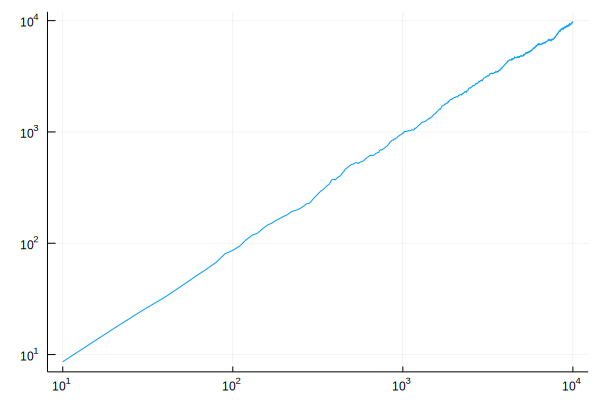

In [6]:
plot(Accumulated_Fly_Time, MSD_Array, key = false)
plot!(xscale = :log10, yscale = :log10)

# Zona de testeo